## Imports

In [1]:
import glob
import os
import random
from typing import Tuple, Any, Callable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # A fix for some strange matplotlib error

In [3]:
MODELS_DIR = "models"
DATASET_DIR = "dataset"

In [54]:
IMAGE_SIZE = 224

## Set seed

In [4]:
seed = 44
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Load data

In [5]:
def load_data(dataset_folder_path: str) -> Tuple[pd.DataFrame, torch.Tensor]:
    """
    Returns pd.Dataframe with targets and torch.tensor with photo data
    """
    df = None
    photos = []
    curr_photo_id = 0
    for csv_file in glob.glob(f"{dataset_folder_path}/*.csv"):
        folder_df = pd.read_csv(
            csv_file, header=None, names=["filename", "forward", "left"]
        )
        photo_folder_name = os.path.splitext(csv_file)[0]
        folder_df["folder_name"] = photo_folder_name
        photo_paths = glob.glob(f"{photo_folder_name}/*.jpg")
        for photo_path in photo_paths:
            photos.append(torchvision.io.read_image(photo_path))
        folder_df["photo_id"] = folder_df.index + curr_photo_id
        curr_photo_id += folder_df.index.max() + 1
        if df is None:
            df = folder_df
        else:
            df = pd.concat([df, folder_df], axis=0)
    df = df.set_index("photo_id")
    photos = torch.from_numpy(np.array(photos))
    return df, photos


df, photos = load_data(DATASET_DIR)
df

,filename,forward,left,folder_name
photo_id,,,,
0,24,0.039062,0.000000,dataset\1652875851.3497071
1,25,0.210938,0.000000,dataset\1652875851.3497071
2,26,0.390625,0.000000,dataset\1652875851.3497071
3,27,0.421875,0.000000,dataset\1652875851.3497071
4,28,0.421875,0.000000,dataset\1652875851.3497071
...,...,...,...,...
7579,113,0.398438,0.992188,dataset\1653043549.5187616
7580,114,0.367188,0.992188,dataset\1653043549.5187616
7581,115,0.367188,0.992188,dataset\1653043549.5187616


## Dataset

In [148]:
class JetbotDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        images: torch.Tensor,
        transforms: list | None = None,
        image_transforms: list | None = None,
        normalize_images: bool = True,
    ) -> None:
        """
        df: pd.DataFrame loaded by load_data()
        images: torch.tensor with image data loaded by load_data()
        transforms: a list of transforms to augment the data with
        """
        super().__init__()
        if transforms is None:
            transforms = []
        self.df = df
        self.images = images
        self.transforms = transforms
        self.normalize_images = normalize_images
        self.image_transforms = image_transforms
        if image_transforms is None:
            self.image_transforms = []

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.df.iloc[index]
        target = torch.tensor([sample.forward, sample.left], dtype=torch.float32)
        img = self.images[index].float()
        if self.normalize_images:
            img = img / 255.0
        for transform in self.transforms:
            img, target = transform(img, target)

        for transform in self.image_transforms:
            img = transform(img)

        return img, target

In [149]:
def display_image(img: torch.Tensor, target: torch.Tensor = None):
    temp_img = img.numpy().transpose((1, 2, 0))
    if img.max() > 1.0:  # the images are not normalized
        temp_img = temp_img.astype(np.uint8)
    plt.imshow(temp_img)
    if target is not None:
        plt.text(
            0,
            -10,
            f'Target: [{",".join([str(i) for i in target])}]',
            fontsize="x-large",
        )

## Transforms

In [176]:
import torchvision.transforms.functional


class RandomJetbotHorizontalFlip(torch.nn.Module):
    def __init__(self, p: float = 0.5) -> None:
        super().__init__()
        self.p = p

    def forward(self, *inputs: Any) -> Any:
        img, target = inputs
        if np.random.random() <= self.p:  # Flip
            img = torchvision.transforms.functional.hflip(img)
            target[1] *= -1  # Flip 'left' component
        return img, target


class RandomJetbotGamma(torch.nn.Module):
    def __init__(self, p: float = 0.5, gamma_range: tuple[float, float] = (0.1, 3)):
        super().__init__()
        self.p = p
        self.gamma_range = gamma_range

    def forward(self, img: torch.Tensor, target: torch.Tensor):
        if np.random.random() < self.p:
            gamma = np.random.uniform(self.gamma_range[0], self.gamma_range[1])
            img = torchvision.transforms.functional.adjust_gamma(img, gamma)
        return img, target


class CropJetbotTop(nn.Module): # Keeps only the road, as the top part of the image is mostly irrelevant
    def __init__(self, percent_crop: float = 0.3):
        super().__init__()
        assert percent_crop <= 1.0
        self.top = int(IMAGE_SIZE * percent_crop)
        self.height = int(IMAGE_SIZE * (1 - percent_crop))

    def forward(self, img: torch.Tensor):
        return torchvision.transforms.functional.resized_crop(
            img, self.top, 0, self.height, IMAGE_SIZE, (IMAGE_SIZE, IMAGE_SIZE)
        )


# Vertical flip doesn't make sense in our problem

train_transforms = [
    RandomJetbotHorizontalFlip(p=0.5),
    RandomJetbotGamma(p=0.5, gamma_range=(0.6, 1.4))
]  # Feel free to add more
test_transforms = []  # Test on original examples
image_transforms = [CropJetbotTop()]

0.9376836619816619


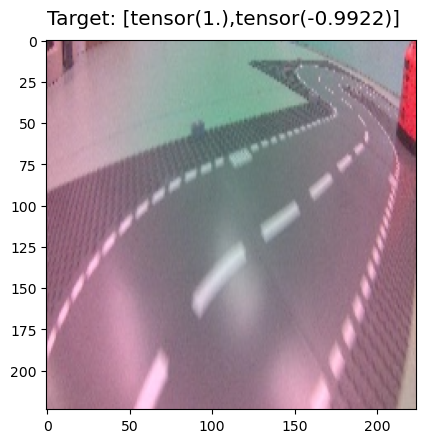

In [168]:
dataset = JetbotDataset(
    df,
    photos,
    train_transforms,
    image_transforms=image_transforms,
    normalize_images=True,
)
img, target = dataset[5911]
display_image(img, target)

## Train-test-validation split

In [189]:
train_size = 0.7
val_size = 0.15
test_size = 1 - (train_size + val_size)
batch_size = 64

data_indices = np.random.permutation(np.arange(df.shape[0]))

train_end_index = int(len(data_indices) * train_size)
val_end_index = train_end_index + int(len(data_indices) * val_size)

train_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[data_indices[:train_end_index]],
        photos[data_indices[:train_end_index]],
        transforms=train_transforms,
        image_transforms=image_transforms,
        normalize_images=True
    ),
    batch_size=batch_size,
)

val_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[data_indices[train_end_index:val_end_index]],
        photos[data_indices[train_end_index:val_end_index]],
        image_transforms=image_transforms,
        normalize_images=True
    ),
    batch_size=batch_size,
)

test_dataloader = DataLoader(
    JetbotDataset(
        df.iloc[data_indices[val_end_index:]],
        photos[data_indices[val_end_index:]],
        image_transforms=image_transforms,
        normalize_images=True
    ),
    batch_size=batch_size,
)

## Training / Evaluation functions.

In [195]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.weights = torch.Tensor([1, 30])

    def forward(self, predictions, targets):
        loss = torch.mean(self.weights * (predictions - targets) ** 2)
        return loss

In [171]:
from pathlib import Path


class Trainer:
    def __init__(
        self,
        model: nn.Module,
        save_dir: str | Path,
        save_name: str,
        optimizer: torch.optim.Optimizer,
        loss_func: Callable[..., torch.Tensor],
    ):
        self.model = model
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.save_dir = Path(save_dir)
        self.save_name = save_name
        self.history = {"train_loss": [], "valid_loss": []}

        self.min_valid_loss = np.inf

    def train_model(
        self,
        epochs: int,
        trainloader: DataLoader,
        validloader: DataLoader,
        force_cuda: bool = False,
    ):
        if force_cuda and torch.cuda.is_available():
            self.model.cuda()

        for e in range(epochs):
            train_loss = 0.0
            self.model.train()  # Optional when not using Model Specific layer
            for data, labels in tqdm(trainloader):
                if force_cuda and torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()

                self.optimizer.zero_grad()
                target = self.model(data)
                loss = self.loss_func(target, labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            valid_loss = 0.0
            self.model.eval()  # Optional when not using Model Specific layer
            for data, labels in tqdm(validloader):
                if torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()

                target = self.model(data)
                loss = self.loss_func(target, labels)
                valid_loss += loss.item()

            avg_train_loss = train_loss / len(trainloader)
            avg_valid_loss = valid_loss / len(validloader)

            self.history["train_loss"].append(avg_train_loss)
            self.history["valid_loss"].append(avg_valid_loss)

            print(
                f"Epoch {e+1} \t\t Training Loss: {avg_train_loss} \t\t Validation Loss: {avg_valid_loss}"
            )

            if self.min_valid_loss > avg_valid_loss:
                print(
                    f"Validation Loss Decreased({self.min_valid_loss:.6f}--->{avg_valid_loss:.6f}) \t Saving The Model"
                )
                self.min_valid_loss = avg_valid_loss
                # Saving State Dict
                torch.save(
                    self.model.state_dict(),
                    self.save_dir / f"{self.save_name}_best.pth",
                )
        torch.save(
            self.model.state_dict(), self.save_dir / f"{self.save_name}_last.pth"
        )

    def plot_losses(self, ax: plt.Axes | None = None):
        if ax is None:
            fig, ax = plt.subplots(1, 1)
            ax: plt.Axes
        ax.plot(self.history["train_loss"], label="train_loss")
        ax.plot(self.history["valid_loss"], label="valid_loss")
        ax.title("Training History")
        ax.legend()

In [172]:
def evaluate_model(
    model: nn.Module,
    dataloader: DataLoader,
    loss_func: callable,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    model.to(device)
    model.eval()

    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            loss = loss_func(outputs, labels)

            total_loss += loss.item() * data.size(0)
            total_samples += data.size(0)

    avg_loss = total_loss / total_samples
    return avg_loss

## Model 1: Classical Convolution

In [33]:
class ClassicConv(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(10, 50, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.fully_connected = nn.Sequential(
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 2),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.global_pool(x)
        x = x.flatten(1, -1)
        x = self.fully_connected(x)
        return x

In [34]:
conv_model = ClassicConv()
optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)
loss = nn.MSELoss()
print(conv_model)
print(f"Total number of parameters = {sum(p.numel() for p in conv_model.parameters())}")

ClassicConv(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 50, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (global_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (fully_connected): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=2, bias=True)
    (5): Tanh()
  )
)
Total number of p

In [35]:
conv_trainer = Trainer(
    model=conv_model,
    optimizer=optimizer,
    loss_func=loss,
    save_dir=MODELS_DIR,
    save_name="conv",
)

In [36]:
conv_trainer.train_model(
    epochs=15, trainloader=train_dataloader, validloader=val_dataloader, force_cuda=True
)

100%|██████████| 18/18 [00:01<00:00, 14.89it/s]


Epoch 1 		 Training Loss: 0.29197693104485434 		 Validation Loss: 0.6643747107850181
Validation Loss Decreased(inf--->0.664375) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 14.89it/s]


Epoch 2 		 Training Loss: 0.23471018887427916 		 Validation Loss: 0.6608411976032786
Validation Loss Decreased(11.958745--->0.660841) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 12.05it/s]


Epoch 3 		 Training Loss: 0.23507268098463496 		 Validation Loss: 0.6625819727778435
Validation Loss Decreased(11.895142--->0.662582) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 12.08it/s]


Epoch 4 		 Training Loss: 0.23460832615214658 		 Validation Loss: 0.6612517486015955
Validation Loss Decreased(11.926476--->0.661252) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 13.59it/s]


Epoch 5 		 Training Loss: 0.23461504819163356 		 Validation Loss: 0.6829417082998488
Validation Loss Decreased(11.902531--->0.682942) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 16.62it/s]


Epoch 6 		 Training Loss: 0.23246452768883072 		 Validation Loss: 0.6959487232897017
Validation Loss Decreased(12.292951--->0.695949) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 13.57it/s]


Epoch 7 		 Training Loss: 0.22280070634491472 		 Validation Loss: 0.584152940246794
Validation Loss Decreased(12.527077--->0.584153) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  8.82it/s]


Epoch 8 		 Training Loss: 0.19652499096939363 		 Validation Loss: 0.507628846499655
Validation Loss Decreased(10.514753--->0.507629) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 12.06it/s]


Epoch 9 		 Training Loss: 0.17318007816751319 		 Validation Loss: 0.4286498841312196
Validation Loss Decreased(9.137319--->0.428650) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 16.56it/s]


Epoch 10 		 Training Loss: 0.16185497869569135 		 Validation Loss: 0.41673936198155087
Validation Loss Decreased(7.715698--->0.416739) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 16.39it/s]


Epoch 11 		 Training Loss: 0.14792941618396574 		 Validation Loss: 0.4255980716811286
Validation Loss Decreased(7.501309--->0.425598) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 16.97it/s]


Epoch 12 		 Training Loss: 0.14281480175903044 		 Validation Loss: 0.4055880813135041
Validation Loss Decreased(7.660765--->0.405588) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  6.38it/s]


Epoch 13 		 Training Loss: 0.13821148181177048 		 Validation Loss: 0.3920016868246926
Validation Loss Decreased(7.300585--->0.392002) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 12.87it/s]


Epoch 14 		 Training Loss: 0.1321390871721578 		 Validation Loss: 0.38099173208077747
Validation Loss Decreased(7.056030--->0.380992) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 14.30it/s]

Epoch 15 		 Training Loss: 0.13171785818525109 		 Validation Loss: 0.36987975819243324
Validation Loss Decreased(6.857851--->0.369880) 	 Saving The Model


In [18]:
conv_model.load_state_dict(torch.load("conv_best.pth"))

avg_loss = evaluate_model(conv_model, test_dataloader, nn.MSELoss())
print(f"Test Loss: {avg_loss:.4f}")

Test Loss: 0.1190


## Model 2: deeper conv model

In [203]:
class DeepConv(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(16),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(32),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(64),
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.BatchNorm2d(128),
        )
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
           nn.MaxPool2d(kernel_size=(2, 2)),
        )

        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.fully_connected = nn.Sequential(
            #nn.Linear(128, 64),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.global_pool(x)
        x = x.flatten(1, -1)
        x = self.fully_connected(x)
        return x

In [204]:
deep_conv_model = DeepConv()
optimizer = torch.optim.Adam(deep_conv_model.parameters())
loss = CustomLoss()
print(deep_conv_model)
print(
    f"Total number of parameters = {sum(p.numel() for p in deep_conv_model.parameters())}"
)

DeepConv(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), st

In [211]:
deep_conv_trainer = Trainer(
    model=deep_conv_model,
    save_dir=MODELS_DIR,
    save_name="deep_conv",
    optimizer=optimizer,
    loss_func=nn.MSELoss(),
)

In [212]:
deep_conv_trainer.train_model(
    15, trainloader=train_dataloader, validloader=val_dataloader, force_cuda=True
)

100%|██████████| 18/18 [00:04<00:00,  3.77it/s]


Epoch 1 		 Training Loss: 0.07347471738256604 		 Validation Loss: 0.09587707701656553
Validation Loss Decreased(inf--->0.095877) 	 Saving The Model


100%|██████████| 18/18 [00:05<00:00,  3.46it/s]


Epoch 2 		 Training Loss: 0.06365900401429958 		 Validation Loss: 0.09366832301020622
Validation Loss Decreased(0.095877--->0.093668) 	 Saving The Model


100%|██████████| 18/18 [00:05<00:00,  3.45it/s]


Epoch 3 		 Training Loss: 0.060108545449483824 		 Validation Loss: 0.09200624852544731
Validation Loss Decreased(0.093668--->0.092006) 	 Saving The Model


100%|██████████| 18/18 [00:04<00:00,  3.63it/s]


Epoch 4 		 Training Loss: 0.05717159125460199 		 Validation Loss: 0.09107549985249837
Validation Loss Decreased(0.092006--->0.091075) 	 Saving The Model


100%|██████████| 18/18 [00:04<00:00,  3.70it/s]


Epoch 5 		 Training Loss: 0.05534516862896552 		 Validation Loss: 0.09026368707418442
Validation Loss Decreased(0.091075--->0.090264) 	 Saving The Model


100%|██████████| 18/18 [00:05<00:00,  3.31it/s]


Epoch 6 		 Training Loss: 0.053565689845077966 		 Validation Loss: 0.08927349001169205
Validation Loss Decreased(0.090264--->0.089273) 	 Saving The Model


100%|██████████| 18/18 [00:04<00:00,  3.62it/s]


Epoch 7 		 Training Loss: 0.0508368007659194 		 Validation Loss: 0.08877330770095189
Validation Loss Decreased(0.089273--->0.088773) 	 Saving The Model


100%|██████████| 18/18 [00:04<00:00,  3.66it/s]


Epoch 8 		 Training Loss: 0.04822208164596414 		 Validation Loss: 0.08883271821671063


100%|██████████| 18/18 [00:04<00:00,  3.90it/s]


Epoch 9 		 Training Loss: 0.04772524537900126 		 Validation Loss: 0.0882995706051588
Validation Loss Decreased(0.088773--->0.088300) 	 Saving The Model


100%|██████████| 18/18 [00:04<00:00,  3.88it/s]


Epoch 10 		 Training Loss: 0.04675098643245467 		 Validation Loss: 0.08858842299216324


100%|██████████| 18/18 [00:04<00:00,  3.85it/s]


Epoch 11 		 Training Loss: 0.04510397780462202 		 Validation Loss: 0.08803108541501893
Validation Loss Decreased(0.088300--->0.088031) 	 Saving The Model


100%|██████████| 18/18 [00:04<00:00,  3.92it/s]


Epoch 12 		 Training Loss: 0.04425241448074938 		 Validation Loss: 0.0873003691020939
Validation Loss Decreased(0.088031--->0.087300) 	 Saving The Model


100%|██████████| 18/18 [00:04<00:00,  4.04it/s]


Epoch 13 		 Training Loss: 0.04196166251617742 		 Validation Loss: 0.08664504086805715
Validation Loss Decreased(0.087300--->0.086645) 	 Saving The Model


100%|██████████| 18/18 [00:04<00:00,  4.07it/s]


Epoch 14 		 Training Loss: 0.0401674205190446 		 Validation Loss: 0.08754756922523181


100%|██████████| 18/18 [00:04<00:00,  3.81it/s]

Epoch 15 		 Training Loss: 0.0386428926364485 		 Validation Loss: 0.08848023869925076


In [213]:
deep_conv_model.load_state_dict(torch.load(f"{MODELS_DIR}/deep_conv_best.pth"))

avg_loss = evaluate_model(deep_conv_model, test_dataloader, nn.MSELoss())
print(f"Test Loss: {avg_loss:.4f}")

Test Loss: 0.0832


1.3983882376455536
PREDICTION: tensor([[0.9128, 0.8217]], grad_fn=<TanhBackward0>)


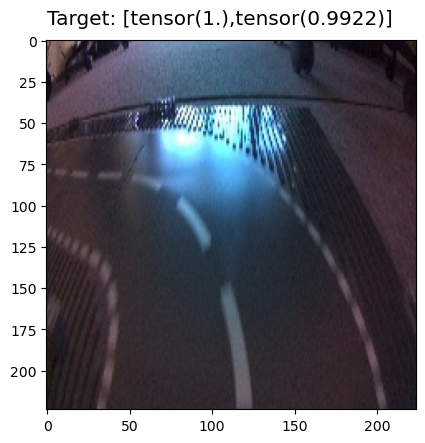

In [280]:
d = dataset[507]
img = d[0]
target = d[1]
preds = deep_conv_model(torch.from_numpy(np.array([img])))

print(f"PREDICTION: {preds}")
display_image(img, target)

## Model 3: Resnet alike

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else None
        )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.skip:
            identity = self.skip(identity)

        out += identity
        out = self.relu(out)
        return out


class ResNetLike(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.res_block1 = ResidualBlock(16, 32)
        self.res_block2 = ResidualBlock(32, 64)
        self.res_block3 = ResidualBlock(64, 128)
        self.global_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.fully_connected = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block1(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.global_pool(x)
        x = x.flatten(1, -1)
        x = self.fully_connected(x)
        return x

In [24]:
resnetlike_model = ResNetLike()
optimizer = torch.optim.Adam(resnetlike_model.parameters())
loss = nn.MSELoss()
print(resnetlike_model)
print(
    f"Total number of parameters = {sum(p.numel() for p in resnetlike_model.parameters())}"
)

ResNetLike(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (res_block1): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (res_block2): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [ ]:
resnetlike_trainer = Trainer(
    model=resnetlike_model,
    save_dir=MODELS_DIR,
    save_name="resnetlike",
    optimizer=optimizer,
    loss_func=loss,
)

In [ ]:
resnetlike_trainer.train_model(
    epochs=15, trainloader=train_dataloader, validloader=val_dataloader, force_cuda=True
)

In [26]:
resnetlike_model.load_state_dict(torch.load(f"{MODELS_DIR}/resnetlike_best.pth"))

avg_loss = evaluate_model(resnetlike_model, test_dataloader, nn.MSELoss())
print(f"Test Loss: {avg_loss:.4f}")

Test Loss: 0.1143


## Model 4: ResNet Regression (using pretrained weights)

In [30]:
class ResnetRegressor(nn.Module):
    def __init__(
        self, weights: models.ResNet18_Weights = models.ResNet18_Weights.DEFAULT
    ):
        super().__init__()
        self.resnet = models.resnet18(weights=weights)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 2)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.resnet(x)
        x = self.tanh(x)
        return x

In [20]:
resnet_reg_model = ResnetRegressor(models.ResNet18_Weights.DEFAULT)
optimizer = torch.optim.Adam(resnet_reg_model.parameters())
loss = nn.MSELoss()
print(resnet_reg_model)
print(
    f"Total number of parameters = {sum(p.numel() for p in resnet_reg_model.parameters())}"
)

ResnetRegressor(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [24]:
resnet_reg_model.load_state_dict(torch.load(f"{MODELS_DIR}/resnetreg_best_overall.pth"))

<All keys matched successfully>

In [25]:
resnetreg_trainer = Trainer(
    model=resnet_reg_model,
    save_dir=MODELS_DIR,
    save_name="resnetreg",
    optimizer=optimizer,
    loss_func=loss,
)

In [26]:
resnetreg_trainer.train_model(
    epochs=30, trainloader=train_dataloader, validloader=val_dataloader, force_cuda=True
)

100%|██████████| 18/18 [00:02<00:00,  7.47it/s]


Epoch 1 		 Training Loss: 0.08506932603307517 		 Validation Loss: 0.11013158162434895
Validation Loss Decreased(inf--->0.110132) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  8.81it/s]


Epoch 2 		 Training Loss: 0.08547341711370342 		 Validation Loss: 0.09983751467532581
Validation Loss Decreased(0.110132--->0.099838) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00,  9.46it/s]


Epoch 3 		 Training Loss: 0.08190824692866888 		 Validation Loss: 0.09242665064003733
Validation Loss Decreased(0.099838--->0.092427) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00,  9.77it/s]


Epoch 4 		 Training Loss: 0.08000445599297443 		 Validation Loss: 0.0891178057839473
Validation Loss Decreased(0.092427--->0.089118) 	 Saving The Model


100%|██████████| 18/18 [00:02<00:00,  8.75it/s]


Epoch 5 		 Training Loss: 0.07768140248505466 		 Validation Loss: 0.08969793034096558


100%|██████████| 18/18 [00:01<00:00, 10.10it/s]


Epoch 6 		 Training Loss: 0.07324078607271953 		 Validation Loss: 0.09065889815489452


100%|██████████| 18/18 [00:01<00:00, 10.21it/s]


Epoch 7 		 Training Loss: 0.07180923425469053 		 Validation Loss: 0.08483208695219623
Validation Loss Decreased(0.089118--->0.084832) 	 Saving The Model


100%|██████████| 18/18 [00:01<00:00, 10.40it/s]


Epoch 8 		 Training Loss: 0.06725783524922578 		 Validation Loss: 0.12106564309861925


100%|██████████| 18/18 [00:01<00:00, 10.04it/s]


Epoch 9 		 Training Loss: 0.06959815826042588 		 Validation Loss: 0.08927170083754593


100%|██████████| 18/18 [00:01<00:00, 10.15it/s]


Epoch 10 		 Training Loss: 0.06311226494789841 		 Validation Loss: 0.12738436253534424


100%|██████████| 18/18 [00:02<00:00,  6.96it/s]


Epoch 11 		 Training Loss: 0.06618921297142305 		 Validation Loss: 0.10807680462797482


100%|██████████| 18/18 [00:02<00:00,  7.41it/s]


Epoch 12 		 Training Loss: 0.06316748692328672 		 Validation Loss: 0.09995982216464148


100%|██████████| 18/18 [00:01<00:00,  9.73it/s]


Epoch 13 		 Training Loss: 0.05880744205451155 		 Validation Loss: 0.1389556158747938


100%|██████████| 18/18 [00:01<00:00,  9.13it/s]


Epoch 14 		 Training Loss: 0.05695432512067169 		 Validation Loss: 0.1030478866563903


100%|██████████| 18/18 [00:02<00:00,  8.37it/s]


Epoch 15 		 Training Loss: 0.052282475608300016 		 Validation Loss: 0.09327078589962588


100%|██████████| 18/18 [00:01<00:00, 10.28it/s]


Epoch 16 		 Training Loss: 0.048092002879424264 		 Validation Loss: 0.11750242031282848


100%|██████████| 18/18 [00:01<00:00, 10.07it/s]


Epoch 17 		 Training Loss: 0.04531928483980248 		 Validation Loss: 0.09528110610942046


100%|██████████| 18/18 [00:01<00:00, 10.17it/s]


Epoch 18 		 Training Loss: 0.04044139735310911 		 Validation Loss: 0.10426001126567523


100%|██████████| 18/18 [00:01<00:00, 10.07it/s]


Epoch 19 		 Training Loss: 0.03850617568311562 		 Validation Loss: 0.11497779397500886


100%|██████████| 18/18 [00:01<00:00, 10.33it/s]


Epoch 20 		 Training Loss: 0.037823765145906484 		 Validation Loss: 0.12170497286650869


100%|██████████| 18/18 [00:01<00:00, 10.30it/s]


Epoch 21 		 Training Loss: 0.03613084130527743 		 Validation Loss: 0.09794229848517312


100%|██████████| 18/18 [00:01<00:00, 10.28it/s]


Epoch 22 		 Training Loss: 0.03423074069601226 		 Validation Loss: 0.10764254422651397


100%|██████████| 18/18 [00:02<00:00,  7.04it/s]


Epoch 23 		 Training Loss: 0.031603504028395714 		 Validation Loss: 0.12333084725671345


100%|██████████| 18/18 [00:01<00:00,  9.70it/s]


Epoch 24 		 Training Loss: 0.029403780373823213 		 Validation Loss: 0.09998006518516275


100%|██████████| 18/18 [00:01<00:00,  9.94it/s]


Epoch 25 		 Training Loss: 0.028248045627162398 		 Validation Loss: 0.1100332240263621


100%|██████████| 18/18 [00:01<00:00, 10.14it/s]


Epoch 26 		 Training Loss: 0.03082666349743145 		 Validation Loss: 0.10519912507798937


100%|██████████| 18/18 [00:02<00:00,  8.48it/s]


Epoch 27 		 Training Loss: 0.03856538016214428 		 Validation Loss: 0.13092847582366732


100%|██████████| 18/18 [00:02<00:00,  8.94it/s]


Epoch 28 		 Training Loss: 0.03761496541864542 		 Validation Loss: 0.10167262123690711


100%|██████████| 18/18 [00:01<00:00,  9.79it/s]


Epoch 29 		 Training Loss: 0.0270311569862337 		 Validation Loss: 0.09763393344150649


100%|██████████| 18/18 [00:01<00:00, 10.02it/s]


Epoch 30 		 Training Loss: 0.02364512720336038 		 Validation Loss: 0.10060230890909831


In [24]:
resnet_reg_model.load_state_dict(torch.load(f"{MODELS_DIR}/resnetreg_best.pth"))

avg_loss = evaluate_model(resnet_reg_model, test_dataloader, nn.MSELoss())
print(f"Test Loss: {avg_loss:.4f}")

Test Loss: 0.0774


## Model 5: Squeezenet

In [196]:
# Needs those transforms: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

squeezenet_model = models.squeezenet1_1()

squeezenet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 256, kernel_size=1),
    nn.Tanh(),
    nn.Conv2d(256, 2, kernel_size=3),
    nn.AvgPool2d(9),
    nn.Tanh(),
)

optimizer = torch.optim.SGD(squeezenet_model.parameters(), lr=0.1)
loss = CustomLoss()

print(squeezenet_model)
print(
    f"Total number of parameters = {sum(p.numel() for p in squeezenet_model.parameters())}"
)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [197]:
squeezenet_trainer = Trainer(
    model=squeezenet_model,
    save_dir=MODELS_DIR,
    save_name="squeezenet",
    optimizer=optimizer,
    loss_func=loss,
)

In [198]:
squeezenet_trainer.train_model(
    epochs=30,
    trainloader=train_dataloader,
    validloader=val_dataloader,
    force_cuda=False,
)

100%|██████████| 18/18 [00:07<00:00,  2.27it/s]


Epoch 1 		 Training Loss: 21.13980741385954 		 Validation Loss: 20.699947463141548
Validation Loss Decreased(inf--->20.699947) 	 Saving The Model


100%|██████████| 18/18 [00:08<00:00,  2.18it/s]


Epoch 2 		 Training Loss: 20.98449407140893 		 Validation Loss: 20.699947357177734
Validation Loss Decreased(20.699947--->20.699947) 	 Saving The Model


 18%|█▊        | 15/83 [00:14<01:04,  1.06it/s]


KeyboardInterrupt: 

In [ ]:
squeezenet_model.load_state_dict(torch.load(f"{MODELS_DIR}/squeezenet_best.pth"))

avg_loss = evaluate_model(squeezenet_model, test_dataloader, CustomLoss())
print(f"Test Loss: {avg_loss:.4f}")

## Exporting to ONNX

In [281]:
import onnxruntime as ort

input_t = torch.randint(0, 256, (1, 3, 224, 224), dtype=torch.float32)


def export_to_onnx(model_cls: type[nn.Module], pth_file: str, onnx_file: str):
    model = model_cls()
    model.load_state_dict(torch.load(pth_file))
    onnx_program = torch.onnx.export(model, input_t, onnx_file, opset_version=11)


def run_onnx_on_dummy_input(onnx_file: str):
    ort_sess = ort.InferenceSession(onnx_file)
    outputs = ort_sess.run(None, {"input.1": input_t.numpy()})
    return outputs

In [33]:
export_to_onnx(
    ResnetRegressor,
    f"{MODELS_DIR}/resnetreg_best_overall.pth",
    f"{MODELS_DIR}/resnetreg_best_overall.onnx",
)

In [36]:
models_cls = [ClassicConv, DeepConv, ResNetLike, ResnetRegressor]
model_names = ["conv", "deep_conv", "resnetlike", "resnet_reg"]
pth_files = [f"{MODELS_DIR}/{model_name}_best.pth" for model_name in model_names]
onnx_files = [fname.replace(".pth", ".onnx") for fname in pth_files]

for model_cls, pth_file, onnx_file in zip(models_cls, pth_files, onnx_files):
    export_to_onnx(model_cls, pth_file, onnx_file)